In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!pip install transformers==3

from transformers import BertTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive')
!ls


In [ ]:
cd CZ4034/

/content/drive/MyDrive/CZ4034


In [ ]:
import pandas as pd

pd.options.display.max_colwidth = 10000

df=pd.read_csv("all_matched.csv")
df.head()

,category,id,title,review,job,place,date,URL,label_1,label_2,unmatched,Unnamed: 11
0,Banks and Financial Services,50,"Good pay, poor work to life balance","Pay was good, consistent bonuses. You work all the time - but it is well compensated for. Little work to life balance. Work most weekends. Consistent incentives.",Loan Originator (Current Employee),"Cleveland, OH","October 23, 2020",https://www.indeed.com/cmp/Quicken-Loans/reviews?start=40,Neutral,Neutral,False,NaN
1,Banks and Financial Services,65,Family environment and great comp/benefits,I loved working with Quicken Loans. As a mortgage banker your time gets lost quick. You don't really realize how much you are working until you take a step back. All positions besides a mortgage banker have a pretty good work-life balance. The best company to work for. Period.,Account Executive/Mortgage Banker (Former Employee),"Detroit, MI","September 21, 2020",https://www.indeed.com/cmp/Quicken-Loans/reviews?start=60,Positive,Positive,False,NaN
2,Banks and Financial Services,66,Penny pinchers and terrible culture,"Company cares more about selling their casinos and buying baseball teams than their technology, processes, and people. 65 hour weeks and you are paid half minimum wage once over 40 hours though are required to stay the full 65. Whatever helps pay for those football tv ads I guess.",Associate Banker (Former Employee),"Phoenix, AZ","September 17, 2020",https://www.indeed.com/cmp/Quicken-Loans/reviews?start=60,Negative,Negative,False,NaN
3,Banks and Financial Services,79,"Amazing organization that has deep rooted ethics based on the idea of ""always doing what is right"".","Alot of job ads say ""uncapped earning potential"" or ""uncapped commission"" to draw folks in but rarely is that relevant for 90% of new hires. However at Quicken Loans you can truly bust your butt and earn a life changing amount of money within your first year. If you can pass the licensing exam and stick it out for the first few months of banking the rewards that follow seem truly endless. After my first 12 calendar months at the company (with the first 4 months not writing loans) I have cleared close to $200,000. With the opportunity to earn such an incredible living, the job does require dedication, flexibility, humility, and the willingness to do what is needed or to go the extra mile to get the job done. The common sleight against the company would be the hours. I typically work about +/- 60 hours a week in addition to clients frequently calling and texting my cell phone while off the clock. This sacrifice is very easy to justify once you start to see success, which can come very fast. I would highly recommend any friends or family to interview at QL. Whether it is for a position in banking, or the thousands of support positions between the family of companies, the opportunity for growth and change is limitless. For the first time in my professional career I can say I have absolute faith in my employer to do right by not only myself but also for each client we interact with.",Senior Mortgage Banker (Current Employee),"Detroit, MI / Remote","July 20, 2020",https://www.indeed.com/cmp/Quicken-Loans/reviews?start=60,Positive,Positive,False,NaN
4,Banks and Financial Services,97,Great Place to Work!,"Wonderful environment and you can tell your leaders really care about you. Working here is rewarding, however you have to be in charge of your own work life balance here.",Technology Recruiter (Former Employee),"Detroit, MI","February 15, 2020",https://www.indeed.com/cmp/Quicken-Loans/reviews?start=80,Positive,Positive,False,NaN


In [ ]:
comment_df = df[['review', 'label_1']]
comment_df = comment_df.rename({'review': 'text','label_1': 'label'}, axis=1)
comment_df = comment_df[comment_df.label != '?']

# print(len(comment_df[comment_df.label == 'Positive']))
# print(len(comment_df[comment_df.label == 'Negative']))
# print(len(comment_df[comment_df.label == 'Neutral']))

print(comment_df.shape)

def convert_numerical(x):
    if x=='Positive':
      return 1
    if x=='Negative':
      return 0
    return -1

comment_df['label'] = comment_df['label'].apply(convert_numerical)
comment_df = comment_df[comment_df['label'] != -1 ]
print(comment_df.shape)
comment_df.head(10)

(1487, 2)
(987, 2)


,text,label
1,I loved working with Quicken Loans. As a mortgage banker your time gets lost quick. You don't really realize how much you are working until you take a step back. All positions besides a mortgage banker have a pretty good work-life balance. The best company to work for. Period.,1
2,"Company cares more about selling their casinos and buying baseball teams than their technology, processes, and people. 65 hour weeks and you are paid half minimum wage once over 40 hours though are required to stay the full 65. Whatever helps pay for those football tv ads I guess.",0
3,"Alot of job ads say ""uncapped earning potential"" or ""uncapped commission"" to draw folks in but rarely is that relevant for 90% of new hires. However at Quicken Loans you can truly bust your butt and earn a life changing amount of money within your first year. If you can pass the licensing exam and stick it out for the first few months of banking the rewards that follow seem truly endless. After my first 12 calendar months at the company (with the first 4 months not writing loans) I have cleared close to $200,000. With the opportunity to earn such an incredible living, the job does require dedication, flexibility, humility, and the willingness to do what is needed or to go the extra mile to get the job done. The common sleight against the company would be the hours. I typically work about +/- 60 hours a week in addition to clients frequently calling and texting my cell phone while off the clock. This sacrifice is very easy to justify once you start to see success, which can come very fast. I would highly recommend any friends or family to interview at QL. Whether it is for a position in banking, or the thousands of support positions between the family of companies, the opportunity for growth and change is limitless. For the first time in my professional career I can say I have absolute faith in my employer to do right by not only myself but also for each client we interact with.",1
4,"Wonderful environment and you can tell your leaders really care about you. Working here is rewarding, however you have to be in charge of your own work life balance here.",1
5,"Quicken Loans was as advertised. You will be expected to work hard and to play hard. In the five years that I was there, I made great friends and learned a ton.",1
7,The company is so inviting during the recruiting process and during training they tell you youâre only working so much to learn everything. Months go by and youâre still working 65-75 hours. They say weâre supposed to have every other weekend off but thatâs not the case we work 15 hours Mon-Fri and every weekend. No work life balance.,0
8,"Culture is great, compensation is not. Is is an enjoyable place to go, but for a technology company, they do have the benefits of most big companies..",1
9,So many perks. Love the QL outings! Great atmosphere Amazing benefits Amazing gifts and prizes all the time. Great culture You make amazing friends The pay is awesome When youâre at work you forget that youâre working 11 or 12 hr days. No complaints at all.,1
11,"Fun, steady paced work environment. Mostly trouble shooting for clients to help them access their QL accounts or guiding the client through the QL site in order to get their 1098 printed.",1
12,Being a Financial Advisor at Morgan Stanley you are exposed to the best thinking on Wall Street. You learn a lot and are able to take what fits you and infuse it into your own practice.,1


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
len(tokenizer.vocab)

28996

In [ ]:
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
  comment_df,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_train, df_val = train_test_split(
  df_train,
  test_size=0.2,
  random_state=RANDOM_SEED
)

In [ ]:
df_train = pd.read_csv("shared_train_set.csv")
df_test = pd.read_csv("shared_test_set.csv")



In [ ]:
df_train_neutral = df_train[df_train['label'] == 0]
df_train_pos = df_train[df_train['label'] == 1]
df_train_neg = df_train[df_train['label'] == 2]
df_train_neutral.shape, df_train_pos.shape, df_train_neg.shape

((390, 2), (422, 2), (377, 2))

In [ ]:
df_test_neutral = df_test[df_test['label'] == 0]
df_test_pos = df_test[df_test['label'] == 1]
df_test_neg = df_test[df_test['label'] == 2]
df_test_neutral.shape, df_test_pos.shape, df_test_neg.shape

((110, 2), (94, 2), (94, 2))

In [ ]:
df_train = pd.concat([df_train_pos,df_train_neg]).sample(frac=1)

In [ ]:
df_test = pd.concat([df_test_pos, df_test_neg]).sample(frac=1)

In [ ]:
def convert_numerical(x):
    if x==1:
      return 1
    return 0

df_train['label'] = df_train['label'].apply(convert_numerical)
df_test['label'] = df_test['label'].apply(convert_numerical)
df_train.label.value_counts()

1    422
0    377
Name: label, dtype: int64

In [ ]:
df_test.label.value_counts()

1    94
0    94
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(
  df_train,
  test_size=0.05,
  random_state=RANDOM_SEED
)

In [ ]:
df_val.label.value_counts()

0    22
1    18
Name: label, dtype: int64

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((631, 2), (158, 2), (198, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
MAX_LEN = 250

BATCH_SIZE = 4
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

model = SentimentClassifier(2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

EPOCHS = 25
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_subjectivity_shared_set.bin')
    best_accuracy = val_acc

Epoch 1/25
----------
Train loss 0.45651032264076197 accuracy 0.8811410459587956
Val   loss 0.39290828540688383 accuracy 0.8924050632911392

Epoch 2/25
----------
Train loss 0.15992383326844406 accuracy 0.971473851030111
Val   loss 0.20129356544348412 accuracy 0.9556962025316456

Epoch 3/25
----------
Train loss 0.05960692145660537 accuracy 0.988906497622821
Val   loss 0.2390933004753606 accuracy 0.9556962025316456

Epoch 4/25
----------
Train loss 0.00020342264247983046 accuracy 1.0
Val   loss 0.24180384481242073 accuracy 0.9620253164556962

Epoch 5/25
----------
Train loss 0.011658472540631596 accuracy 0.9984152139461173
Val   loss 0.327878828721623 accuracy 0.9493670886075949

Epoch 6/25
----------
Train loss 0.008586688428997288 accuracy 0.9984152139461173
Val   loss 0.2891218042469518 accuracy 0.9620253164556962

Epoch 7/25
----------
Train loss 4.4412727554198326e-05 accuracy 1.0
Val   loss 0.29895745103194715 accuracy 0.9620253164556962

Epoch 8/25
----------
Train loss 3.310563

In [ ]:
import pickle
pickle.dump(history,open('train_best_model_state_polarity0.94_history.pkl','wb'))

In [ ]:
torch.save(model.state_dict(), 'best_model_state_polarity0.94.bin')

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

In [ ]:
test_acc.item()

0.9444444444444445

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
class_names = ['neutral', 'polarised']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.97      0.92      0.95       105
   polarised       0.92      0.97      0.94        93

    accuracy                           0.94       198
   macro avg       0.94      0.95      0.94       198
weighted avg       0.95      0.94      0.94       198



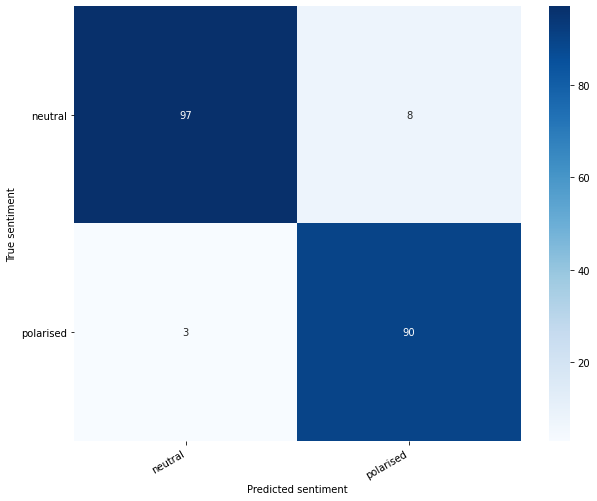

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(10,8))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)